In [1]:
import imp
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
from pyMLaux.functions import evaluate_classification_result, plot_history

# DALLE variations dataset base line: custom cnn model
Check for GPU

In [2]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Basic constants

In [3]:
data_dir = "./../data/dalle-variations-resized"
batch_size = 16
number_images = 50
image_height = 224
image_width = 224
nr_color_channels = 3
seed = 2023

Create ImageDataGenerator for data augmentation of training data

In [4]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   validation_split= 0.2,
                                   cval=0)

Get training data

In [5]:
img_train = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='training', seed=seed,
                                                    class_mode='categorical')
img_train

Found 981 images belonging to 5 classes.


Get test data

In [6]:
img_test = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='validation', seed=seed,
                                                    class_mode='categorical')
img_test

Found 245 images belonging to 5 classes.


Build model

model architecture based on: https://www.kaggle.com/code/tejaswi2003/20bd1a6637-weather-classification-cnn 

In [7]:
model = tf.keras.models.Sequential()
model.add(keras.layers.Conv2D(32,activation="relu",kernel_size=3,input_shape=(image_width, image_height, 3)))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Conv2D(64,activation="relu",kernel_size=3))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Conv2D(128,activation="relu",kernel_size=3))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dense(5,activation="softmax"))


Create model checkpoints

In [8]:
filepath = "./" + 'models/dalle_variations_custom/dalle_variations_custom_{epoch:02d}-{val_accuracy:.4f}.hdf5'
check_point = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')

In [9]:
callbacks_list = [check_point]

In [10]:
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])

In [11]:
history = model.fit(img_train,
                    steps_per_epoch=(len(img_train.filenames) // batch_size), 
                    epochs=25,
                    validation_data=img_test, 
                    validation_steps=(len(img_test.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/25
61/61 [==============================] - 25s 264ms/step - loss: 1.5136 - accuracy: 0.4207 - val_loss: 1.3662 - val_accuracy: 0.6000

Epoch 00001: val_accuracy improved from -inf to 0.60000, saving model to ./models/dalle_variations_custom\dalle_variations_custom_01-0.6000.hdf5
Epoch 2/25
61/61 [==============================] - 19s 317ms/step - loss: 1.2271 - accuracy: 0.6311 - val_loss: 1.0454 - val_accuracy: 0.6833

Epoch 00002: val_accuracy improved from 0.60000 to 0.68333, saving model to ./models/dalle_variations_custom\dalle_variations_custom_02-0.6833.hdf5
Epoch 3/25
61/61 [==============================] - 14s 226ms/step - loss: 0.9455 - accuracy: 0.7150 - val_loss: 0.8168 - val_accuracy: 0.7417

Epoch 00003: val_accuracy improved from 0.68333 to 0.74167, saving model to ./models/dalle_variations_custom\dalle_variations_custom_03-0.7417.hdf5
Epoch 4/25
61/61 [==============================] - 11s 179ms/step - loss: 0.7829 - accuracy: 0.7430 - val_loss: 0.6852 - val_a

Evaluate model

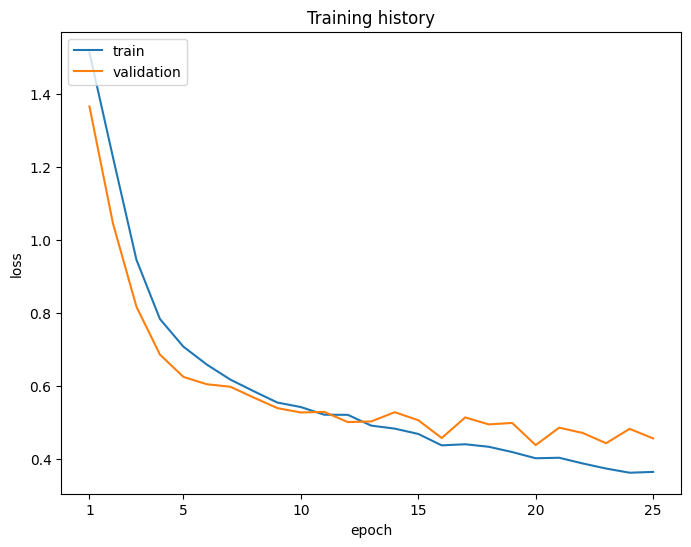

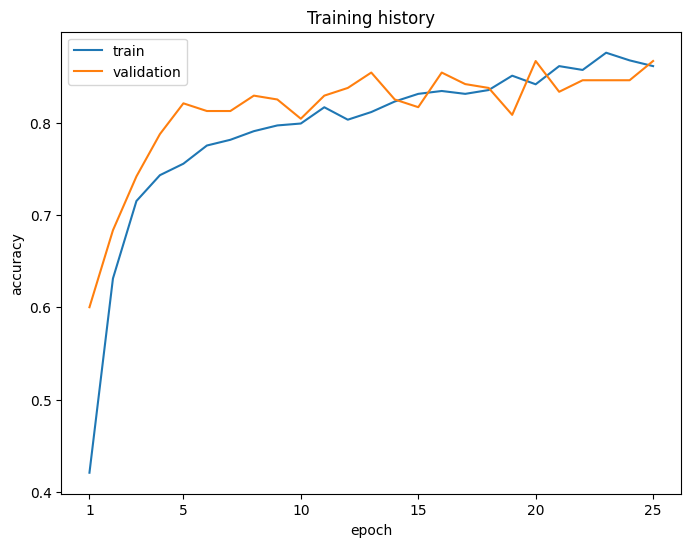

In [12]:
plot_history(history)

Load best model

In [14]:
model = keras.models.load_model("./models/dalle_variations_custom/dalle_variations_custom_20-0.8667.hdf5")
pred = model.predict(img_test, steps=len(img_test.filenames))

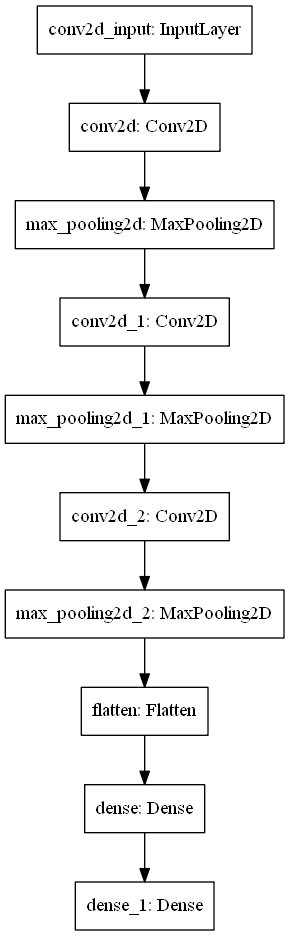

In [15]:
keras.utils.plot_model(model)

In [16]:
evaluate_classification_result(img_test.classes, pred,classes=["foggy","cloudy","sunny","snowy","rainy"])

[[13  6 12 10  8]
 [ 8 10 10  9 12]
 [ 8 12  6 16  7]
 [10  9 10 11  9]
 [ 7 16  4 11 11]]


Class foggy:
    Sensitivity (TPR):  26.531% (13 of 49)
    Specificity (TNR):  83.163% (163 of 196)
    Precision:          28.261% (13 of 46)
    Neg. pred. value:   81.910% (163 of 199)
Class cloudy:
    Sensitivity (TPR):  20.408% (10 of 49)
    Specificity (TNR):  78.061% (153 of 196)
    Precision:          18.868% (10 of 53)
    Neg. pred. value:   79.688% (153 of 192)
Class sunny:
    Sensitivity (TPR):  12.245% (6 of 49)
    Specificity (TNR):  81.633% (160 of 196)
    Precision:          14.286% (6 of 42)
    Neg. pred. value:   78.818% (160 of 203)
Class snowy:
    Sensitivity (TPR):  22.449% (11 of 49)
    Specificity (TNR):  76.531% (150 of 196)
    Precision:          19.298% (11 of 57)
    Neg. pred. value:   79.787% (150 of 188)
Class rainy:
    Sensitivity (TPR):  22.449% (11 of 49)
    Specificity (TNR):  81.633% (160 of 196)
    Precision:          23.404% (11 of 47)
    Neg.

array([[13,  6, 12, 10,  8],
       [ 8, 10, 10,  9, 12],
       [ 8, 12,  6, 16,  7],
       [10,  9, 10, 11,  9],
       [ 7, 16,  4, 11, 11]], dtype=int64)